# Модель обнаружения искусственных текстов

Конопаткин О.В. <br>
624 группа <br>
ВМК МГУ <br>
2021 год <br>

### Установка зависимостей

In [1]:
!pip install -U setuptools pip

In [2]:
!pip install sklearn

In [3]:
!pip install transformers==2.8.0

In [4]:
!pip install torch

In [5]:
!pip install scipy

In [6]:
!pip install joblib

In [7]:
!pip install matplotlib

### Подключение библиотек

In [8]:
import logging
import sys
import os

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics

In [9]:
# source: https://github.com/HendrikStrobelt/detecting-fake-text

import numpy as np
import torch
import time

from transformers import GPT2LMHeadModel, GPT2Tokenizer

class AbstractLanguageChecker():
    """
    Abstract Class that defines the Backend API of GLTR.

    To extend the GLTR interface, you need to inherit this and
    fill in the defined functions.
    """

    def __init__(self):
        '''
        In the subclass, you need to load all necessary components
        for the other functions.
        Typically, this will comprise a tokenizer and a model.
        '''
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")

    def check_probabilities(self, in_text, topk=40):
        '''
        Function that GLTR interacts with to check the probabilities of words

        Params:
        - in_text: str -- The text that you want to check
        - topk: int -- Your desired truncation of the head of the distribution

        Output:
        - payload: dict -- The wrapper for results in this function, described below

        Payload values
        ==============
        bpe_strings: list of str -- Each individual token in the text
        real_topk: list of tuples -- (ranking, prob) of each token
        pred_topk: list of list of tuple -- (word, prob) for all topk
        '''
        raise NotImplementedError

    def postprocess(self, token):
        """
        clean up the tokens from any special chars and encode
        leading space by UTF-8 code '\u0120', linebreak with UTF-8 code 266 '\u010A'
        :param token:  str -- raw token text
        :return: str -- cleaned and re-encoded token text
        """
        raise NotImplementedError


def top_k_logits(logits, k):
    '''
    Filters logits to only the top k choices
    from https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/run_gpt2.py
    '''
    if k == 0:
        return logits
    values, _ = torch.topk(logits, k)
    min_values = values[:, -1]
    return torch.where(logits < min_values,
                       torch.ones_like(logits, dtype=logits.dtype) * -1e10,
                       logits)


#@register_api(name='gpt-2-small')
class LM(AbstractLanguageChecker):
    def __init__(self, model_name_or_path="gpt2"):
        super(LM, self).__init__()
        self.enc = GPT2Tokenizer.from_pretrained(model_name_or_path)
        self.model = GPT2LMHeadModel.from_pretrained(model_name_or_path)
        self.model.to(self.device)
        self.model.eval()
        self.start_token = '<mask>'

    def check_probabilities(self, in_text, topk=40):
        # Process input
        start_t = torch.full((1, 1),
                             self.enc.encoder[self.start_token],
                             device=self.device,
                             dtype=torch.long)
        context = self.enc.encode(in_text)
        context = torch.tensor(context,
                               device=self.device,
                               dtype=torch.long).unsqueeze(0)
        context = torch.cat([start_t, context], dim=1)
        # Forward through the model
        logits, _ = self.model(context)

        # construct target and pred
        yhat = torch.softmax(logits[0, :-1], dim=-1)
        y = context[0, 1:]
        # Sort the predictions for each timestep
        sorted_preds = np.argsort(-yhat.data.cpu().numpy())
        # [(pos, prob), ...]
        real_topk_pos = list(
            [int(np.where(sorted_preds[i] == y[i].item())[0][0])
             for i in range(y.shape[0])])
        real_topk_probs = yhat[np.arange(
            0, y.shape[0], 1), y].data.cpu().numpy().tolist()
        real_topk_probs = list(map(lambda x: round(x, 5), real_topk_probs))

        real_topk = list(zip(real_topk_pos, real_topk_probs))
        # [str, str, ...]
        bpe_strings = [self.enc.decoder[s.item()] for s in context[0]]

        bpe_strings = [self.postprocess(s) for s in bpe_strings]

        # [[(pos, prob), ...], [(pos, prob), ..], ...]
        pred_topk = [
            list(zip([self.enc.decoder[p] for p in sorted_preds[i][:topk]],
                     list(map(lambda x: round(x, 5),
                              yhat[i][sorted_preds[i][
                                      :topk]].data.cpu().numpy().tolist()))))
            for i in range(y.shape[0])]

        pred_topk = [[(self.postprocess(t[0]), t[1]) for t in pred] for pred in pred_topk]
        payload = {'bpe_strings': bpe_strings,
                   'real_topk': real_topk,
                   'pred_topk': pred_topk}
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return payload

    def sample_unconditional(self, length=100, topk=5, temperature=1.0):
        '''
        Sample `length` words from the model.
        Code strongly inspired by
        https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/run_gpt2.py

        '''
        context = torch.full((1, 1),
                             self.enc.encoder[self.start_token],
                             device=self.device,
                             dtype=torch.long)
        prev = context
        output = context
        past = None
        # Forward through the model
        with torch.no_grad():
            for i in range(length):
                logits, past = self.model(prev, past=past)
                logits = logits[:, -1, :] / temperature
                # Filter predictions to topk and softmax
                probs = torch.softmax(top_k_logits(logits, k=topk),
                                      dim=-1)
                # Sample
                prev = torch.multinomial(probs, num_samples=1)
                # Construct output
                output = torch.cat((output, prev), dim=1)

        output_text = self.enc.decode(output[0].tolist())
        return output_text

    def postprocess(self, token):
        with_space = False
        with_break = False
        if token.startswith('Д '):
            with_space = True
            token = token[1:]
            # print(token)
        elif token.startswith('Гў'):
            token = ' '
        elif token.startswith('ДЉ'):
            token = ' '
            with_break = True

        token = '-' if token.startswith('Гў') else token
        token = 'вЂњ' if token.startswith('Дѕ') else token
        token = 'вЂќ' if token.startswith('Дї') else token
        token = "'" if token.startswith('Д»') else token

        if with_space:
            token = '\u0120' + token
        if with_break:
            token = '\u010A' + token

        return token


### Загрузка моделей

In [10]:
%%time
global_path = os.getcwd()
gpt_path = os.path.join(global_path, "ruGPT-3", "rugpt3large_based_on_gpt2") 
# source: https://github.com/sberbank-ai/ru-gpts

lm = LM(gpt_path)

Wall time: 42.7 s


In [11]:
from joblib import load
best_clf = load(os.path.join(global_path, "Models", "AdaBoost_GLTR_all_20k_dataset.joblib"))

### Функции для запуска моделей

In [12]:
from scipy.stats import entropy
from bisect import bisect_left

def pred_entropy(pred):
    return entropy(list(map(lambda elem: elem[1], pred)), base=2)

def GLTR_convert_full(model, text):
    payload = model.check_probabilities(text, topk=10)
    res = []
    for i in range(len(payload["real_topk"])):
        cur_real = payload["real_topk"][i]
        cur_pred = payload["pred_topk"][i]
        res.append({"pos": cur_real[0], "prob": cur_real[1], "top_prob": (cur_pred[0][1], cur_pred[1][1]), "top_10_entropy": pred_entropy(cur_pred)})
    return res

TOP_K_BOXES = [10, 100, 1000]
PROB_BOXES = [0.1 * i for i in range(1, 10)]
ENTROPY_BOXES = [0.3 * i for i in range(1, 12)]

def count_hist(data_list, top_k_boxes=TOP_K_BOXES, prob_boxes=PROB_BOXES, ent_boxes=ENTROPY_BOXES):
    top_k_hist = [0 for i in range(len(top_k_boxes) + 1)]
    prob_hist = [0 for i in range(len(prob_boxes) + 1)]
    ent_hist = [0 for i in range(len(ent_boxes) + 1)]
    for elem in data_list:
        top_k = elem["pos"]
        top_k_hist[bisect_left(top_k_boxes, top_k)] += 1
        prob = elem["prob"] / elem["top_prob"][0] # or maybe elem["top_pprob"][1] / elem["top_prob"][0]
        prob_hist[bisect_left(prob_boxes, prob)] += 1
        ent = elem["top_10_entropy"]
        ent_hist[bisect_left(ent_boxes, ent)] += 1
    div = lambda x: x / len(data_list)
    return list(map(div, top_k_hist + prob_hist + ent_hist))

In [13]:
%%time
test_hist = count_hist(GLTR_convert_full(lm, 
"""«Газпром» и Белоруссия подписали соглашение о поставках российского газа. Как передает ИА «Регнум», глава компании Алексей Миллер сообщил журналистам подробности соглашения.  Цена российского газа для Белоруссии составит с 1 января 100 долларов США за 1000 кубометров и в дальнейшем будет рассчитываться по формуле цены, установленной в контракте. К 2011 году она вырастет до среднеевропейского уровня.   Стоимость транспортировки российского газа по территории Белоруссии вырастет с нынешних 0,75 доллара США за 1000 кубометров на 100 километров до 1,45 доллара США и будет зафиксирована на все пять лет действия контракта.   "Газпром" в ближайшие 4 года выкупит 50% акций "Белтрансгаза" за 2,5 миллиарда долларов в течение 4 лет.   Последние переговоры между сторонами прошли вчера в Москве."""
))

Wall time: 16.2 s


In [14]:
import matplotlib.pyplot as plt

def pretty_predict_one(s):
    hist = count_hist(GLTR_convert_full(lm, s))
    hist_sizes = (len(TOP_K_BOXES) + 1, len(PROB_BOXES) + 1, len(ENTROPY_BOXES) + 1)
    top_k_hist = hist[:hist_sizes[0]]
    prob_hist = hist[hist_sizes[0]:hist_sizes[0]+hist_sizes[1]]
    ent_hist = hist[hist_sizes[0]+hist_sizes[1]:]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
    
    ax1.set_title("top k frequency")
    ax1.bar(np.arange(hist_sizes[0]), top_k_hist, width=-0.9, align="edge", tick_label=TOP_K_BOXES+[""])
    
    ax2.set_title("frac(p) histogram")
    ax2.bar(np.arange(hist_sizes[1]), prob_hist, width=-0.9, align="edge", tick_label=list(map(lambda x: round(x, 1), PROB_BOXES))+["1.0"])
    
    ax3.set_title("top 10 entropy(p) histogram")
    ax3.bar(np.arange(hist_sizes[2]), ent_hist, width=-0.9, align="edge", tick_label=list(map(lambda x: round(x, 1), ENTROPY_BOXES))+[""])
    
    plt.show()
    
    result = best_clf.predict([hist])[0]
    print("Model prediction: {}".format("Natural text (positive)" if result else "Artificial text (negative)"))
    
def pretty_predict(X):
    if isinstance(X, list):
        for elem in X:
            print("Text: \"{}\"".format(elem))
            pretty_predict_one(elem)
    elif isinstance(X, str):
        print("Text: \"{}\"".format(X))
        pretty_predict_one(X)
    else:
        print("X must be list or str")
        raise NotImplemented

### Классификация

Text: "«Газпром» и Белоруссия подписали соглашение о поставках российского газа. Как передает ИА «Регнум», глава компании Алексей Миллер сообщил журналистам подробности соглашения.  Цена российского газа для Белоруссии составит с 1 января 100 долларов США за 1000 кубометров и в дальнейшем будет рассчитываться по формуле цены, установленной в контракте. К 2011 году она вырастет до среднеевропейского уровня.   Стоимость транспортировки российского газа по территории Белоруссии вырастет с нынешних 0,75 доллара США за 1000 кубометров на 100 километров до 1,45 доллара США и будет зафиксирована на все пять лет действия контракта.   "Газпром" в ближайшие 4 года выкупит 50% акций "Белтрансгаза" за 2,5 миллиарда долларов в течение 4 лет.   Последние переговоры между сторонами прошли вчера в Москве."


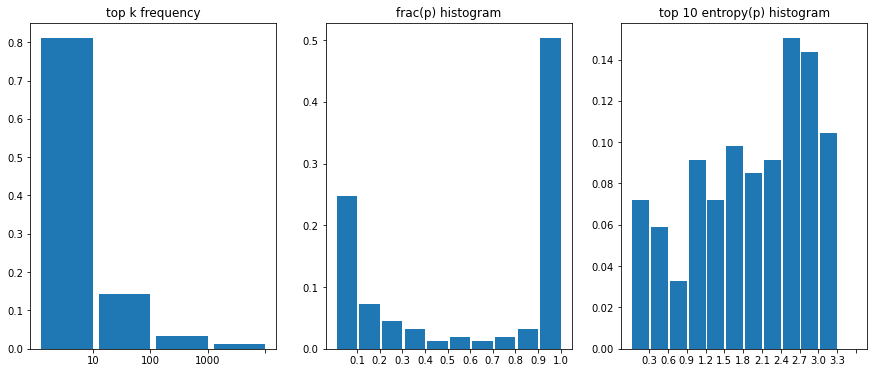

Model prediction: Natural text (positive)
Wall time: 11.6 s


In [15]:
%%time
# natural example
pretty_predict("""«Газпром» и Белоруссия подписали соглашение о поставках российского газа. Как передает ИА «Регнум», глава компании Алексей Миллер сообщил журналистам подробности соглашения.  Цена российского газа для Белоруссии составит с 1 января 100 долларов США за 1000 кубометров и в дальнейшем будет рассчитываться по формуле цены, установленной в контракте. К 2011 году она вырастет до среднеевропейского уровня.   Стоимость транспортировки российского газа по территории Белоруссии вырастет с нынешних 0,75 доллара США за 1000 кубометров на 100 километров до 1,45 доллара США и будет зафиксирована на все пять лет действия контракта.   "Газпром" в ближайшие 4 года выкупит 50% акций "Белтрансгаза" за 2,5 миллиарда долларов в течение 4 лет.   Последние переговоры между сторонами прошли вчера в Москве.""")

Text: "ГУ ФСИН 27 мая открывает горячую линию. Она будет работать всего лишь час - с 11.00 до 12.00. Как сообщили «Фонтанке» в пресс-службе ведомства,  звонки будут приниматься по телефону 8-800-700-75-75.  Власти Москвы планируют потратить около 5 миллиардов рублей на строительство дорог к местам массовых митингов. Соответствующий проект постановления опубликован на сайте правительства столицы, передает РИА «Новости». Согласно документу, на строительство и ремонт дорог будет потрачено около 4,5 миллиарда рублей. В документе говорится, что средства будут направлены в первую очередь на реконструкцию вылетных магистралей и развязок, строительство путепроводов, путепроводны"


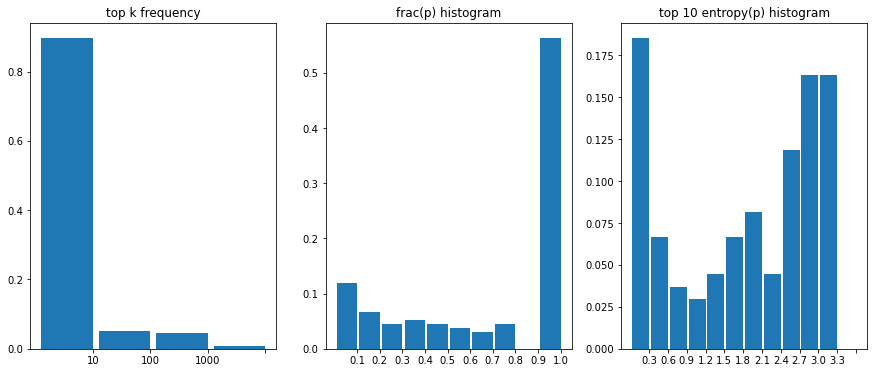

Model prediction: Artificial text (negative)
Wall time: 12.5 s


In [16]:
%%time
# top_k=5, top_p=0.95 example
pretty_predict("""ГУ ФСИН 27 мая открывает горячую линию. Она будет работать всего лишь час - с 11.00 до 12.00. Как сообщили «Фонтанке» в пресс-службе ведомства,  звонки будут приниматься по телефону 8-800-700-75-75.  Власти Москвы планируют потратить около 5 миллиардов рублей на строительство дорог к местам массовых митингов. Соответствующий проект постановления опубликован на сайте правительства столицы, передает РИА «Новости». Согласно документу, на строительство и ремонт дорог будет потрачено около 4,5 миллиарда рублей. В документе говорится, что средства будут направлены в первую очередь на реконструкцию вылетных магистралей и развязок, строительство путепроводов, путепроводны""")

Text: "Около 11 часов утра от помещения изолятора временного содержания ГУВД Петербурга и Ленобласти на Захарьевской,  9, поехал в Железку на митинг за обмен задержанных надолбитников. Далее всё вернулось к той обычной схеме, когда два-три десятка человек организованно в десять утра рвутся к автобусам. В штаб мониторинга ехали вдоль Пушкинской. Временами колонна останавливалась на пролётах лестничных переходов, где несколько дней назад протестующие избивали милиционеров и проводились беспорядки, по крайней мере, на нашем участке. Одновременно со скандированием у телефонной будки, было забросано потомств"


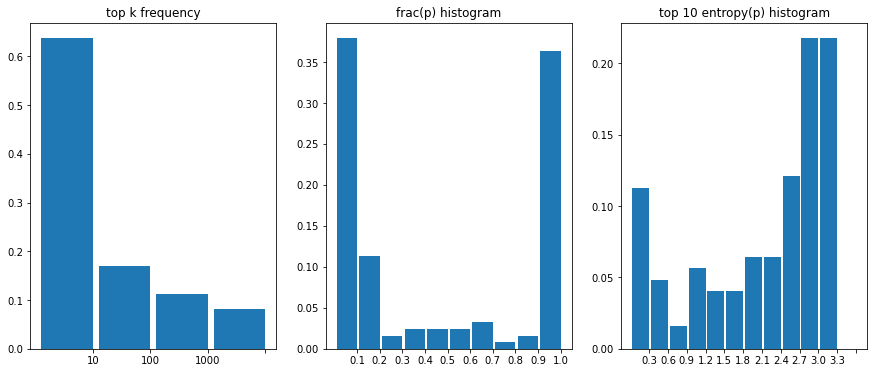

Model prediction: Artificial text (negative)
Wall time: 12.4 s


In [17]:
%%time
# top_k=0, top_p=1.0 example
pretty_predict("""Около 11 часов утра от помещения изолятора временного содержания ГУВД Петербурга и Ленобласти на Захарьевской,  9, поехал в Железку на митинг за обмен задержанных надолбитников. Далее всё вернулось к той обычной схеме, когда два-три десятка человек организованно в десять утра рвутся к автобусам. В штаб мониторинга ехали вдоль Пушкинской. Временами колонна останавливалась на пролётах лестничных переходов, где несколько дней назад протестующие избивали милиционеров и проводились беспорядки, по крайней мере, на нашем участке. Одновременно со скандированием у телефонной будки, было забросано потомств""")